In [1]:
import glob
import os
import numpy as np
import torch
from torch import nn, Tensor
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_name = "facades"

In [2]:
os.makedirs('images', exist_ok=True)

In [3]:
!gdown 12liXbJnLb23OTXJlkMAVNF7zFp0j_ws0

Downloading...
From (original): https://drive.google.com/uc?id=12liXbJnLb23OTXJlkMAVNF7zFp0j_ws0
From (redirected): https://drive.google.com/uc?id=12liXbJnLb23OTXJlkMAVNF7zFp0j_ws0&confirm=t&uuid=feb3cc03-2065-4aa0-8f45-76b24b013533
To: /content/data.zip
100% 31.4M/31.4M [00:01<00:00, 24.9MB/s]


In [4]:
!unzip  data.zip

Archive:  data.zip
  inflating: data/facades/val/99.jpg  
  inflating: data/facades/val/85.jpg  
  inflating: data/facades/val/47.jpg  
  inflating: data/facades/val/56.jpg  
  inflating: data/facades/val/77.jpg  
  inflating: data/facades/val/94.jpg  
  inflating: data/facades/val/28.jpg  
  inflating: data/facades/val/48.jpg  
  inflating: data/facades/val/50.jpg  
  inflating: data/facades/val/69.jpg  
  inflating: data/facades/val/25.jpg  
  inflating: data/facades/val/13.jpg  
  inflating: data/facades/val/89.jpg  
  inflating: data/facades/val/97.jpg  
  inflating: data/facades/val/6.jpg  
  inflating: data/facades/val/61.jpg  
  inflating: data/facades/val/4.jpg  
  inflating: data/facades/val/74.jpg  
  inflating: data/facades/val/49.jpg  
  inflating: data/facades/val/10.jpg  
  inflating: data/facades/val/8.jpg  
  inflating: data/facades/val/68.jpg  
  inflating: data/facades/val/95.jpg  
  inflating: data/facades/val/17.jpg  
  inflating: data/facades/val/15.jpg  
  inflati

# 1. Dataset

In [5]:
import torchvision
from torch.utils.data import Dataset
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, root, transforms=None, split="train"):
        self.transform = torchvision.transforms.Compose(transforms)

        self.files = sorted(glob.glob(os.path.join(root, split) + "/*.*"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        w, h = img.size
        img_A = img.crop((0, 0, w / 2, h))
        img_B = img.crop((w / 2, 0, w, h))

        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.files)

In [6]:
img_height = 256
img_width = 256

transforms = [
    torchvision.transforms.Resize((img_height, img_width), Image.BICUBIC),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

train_set = ImageDataset(root=f"./data/{dataset_name}", transforms=transforms, split="train")
val_set = ImageDataset(root=f"./data/{dataset_name}", transforms=transforms, split="val")

len(train_set), len(val_set)

(400, 100)

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 2. Model

In [8]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = DownSample(in_channels, 64, normalize=False)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512, normalize=False, dropout=0.5)

        self.up1 = UpSample(512, 512, dropout=0.5)
        self.up2 = UpSample(1024, 512, dropout=0.5)
        self.up3 = UpSample(1024, 512, dropout=0.5)
        self.up4 = UpSample(1024, 512, dropout=0.5)
        self.up5 = UpSample(1024, 256)
        self.up6 = UpSample(512, 128)
        self.up7 = UpSample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(512),

            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1),
            nn.Sigmoid()
        )
    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [10]:
generator = Generator()
generator.to(device)

Generator(
  (down1): DownSample(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): DownSample(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): DownSample(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): DownSample(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=

In [11]:
discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (13): Sigmoid()
  )
)

# 3. Training

In [12]:
def sample_images(epoch_done):
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_loader))
    real_A = imgs["B"][:5, ...].to(device)
    real_B = imgs["A"][:5, ...].to(device)
    fake_B = generator(real_A)
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2)
    save_image(img_sample, f"images/epoch_{epoch_done}.png", nrow=5, normalize=True)

save_interval = 10

In [13]:
img_height, img_height // 2 ** 4

(256, 16)

In [14]:
a = next(iter(val_loader))
a['A'][:5,...].size()

torch.Size([5, 3, 256, 256])

In [15]:
EPOCHS = 100

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = torch.nn.BCELoss()
criterion_pixelwise = torch.nn.L1Loss()

lambda_pixel = 100
patch = (1, img_height // 2 ** 4, img_width // 2 ** 4)

hist = {
        "train_G_loss": [],
        "train_D_loss": [],
    }

for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, batch in enumerate(train_loader):

        real_imgs_A = batch["B"].to(device)
        real_imgs_B = batch["A"].to(device)

        valid = torch.ones(real_imgs_A.size(0), *patch).to(device)
        fake = torch.zeros(real_imgs_A.size(0), *patch).to(device)

        # --- Train Generator ---
        optimizer_G.zero_grad()

        fake_imgs_B = generator(real_imgs_A)
        pred_fake = discriminator(fake_imgs_B, real_imgs_A)

        # GAN loss
        G_loss_GAN = criterion(pred_fake, valid)

        # Pixel-wise loss
        G_loss_pixel = criterion_pixelwise(fake_imgs_B, real_imgs_B)

        # Total loss
        G_loss = G_loss_GAN + lambda_pixel * G_loss_pixel

        running_G_loss += G_loss.item()
        G_loss.backward()
        optimizer_G.step()

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        pred_real = discriminator(real_imgs_B, real_imgs_A)
        loss_real = criterion(pred_real, valid)

        pred_fake = discriminator(fake_imgs_B.detach(), real_imgs_A)
        loss_fake = criterion(pred_fake, fake)

        # Total loss
        D_loss = (loss_real + loss_fake) / 2

        running_D_loss += D_loss.item()
        D_loss.backward()
        optimizer_D.step()


    epoch_G_loss = running_G_loss / len(train_loader)
    epoch_D_loss = running_D_loss / len(train_loader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    if epoch % save_interval == 0:
        sample_images(epoch)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100], Train G Loss: 40.7906, Train D Loss: 0.7705
Epoch [2/100], Train G Loss: 37.3760, Train D Loss: 0.6554
Epoch [3/100], Train G Loss: 36.4745, Train D Loss: 0.6090
Epoch [4/100], Train G Loss: 36.3298, Train D Loss: 0.5099
Epoch [5/100], Train G Loss: 36.3066, Train D Loss: 0.4161
Epoch [6/100], Train G Loss: 36.2783, Train D Loss: 0.4219
Epoch [7/100], Train G Loss: 36.2863, Train D Loss: 0.4003
Epoch [8/100], Train G Loss: 35.9517, Train D Loss: 0.2939
Epoch [9/100], Train G Loss: 35.4167, Train D Loss: 0.3897
Epoch [10/100], Train G Loss: 35.6689, Train D Loss: 0.3918
Epoch [11/100], Train G Loss: 35.8903, Train D Loss: 0.3324
Epoch [12/100], Train G Loss: 35.3483, Train D Loss: 0.3705
Epoch [13/100], Train G Loss: 35.0517, Train D Loss: 0.4098
Epoch [14/100], Train G Loss: 34.7793, Train D Loss: 0.3108
Epoch [15/100], Train G Loss: 34.7697, Train D Loss: 0.3144
Epoch [16/100], Train G Loss: 34.3032, Train D Loss: 0.2875
Epoch [17/100], Train G Loss: 33.6120, Train D Lo

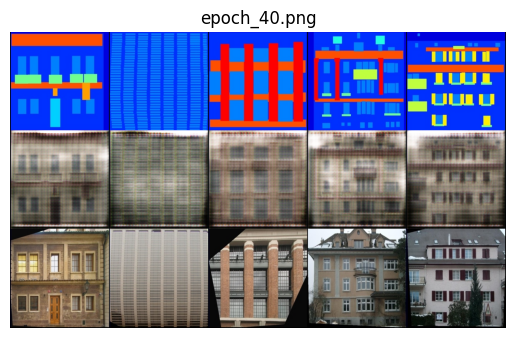

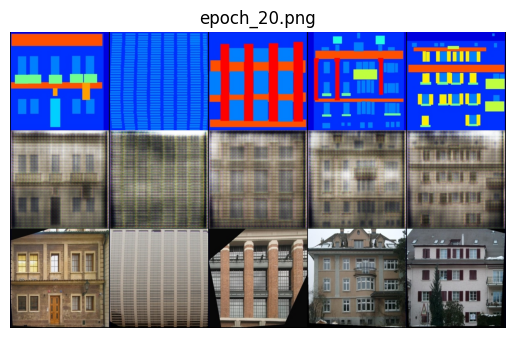

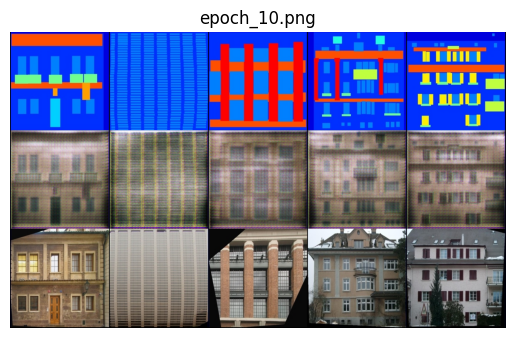

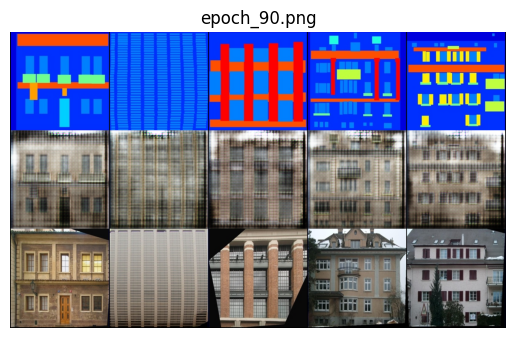

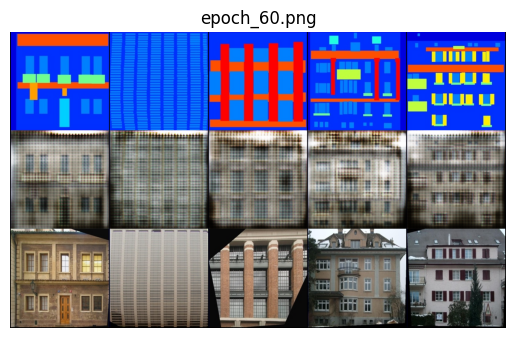

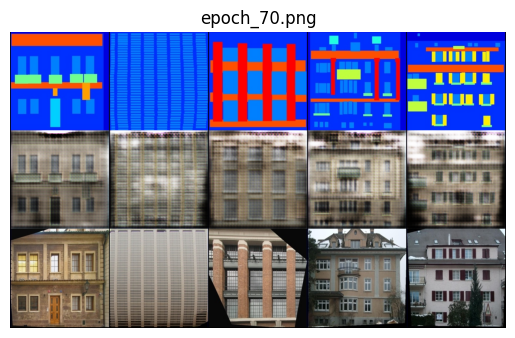

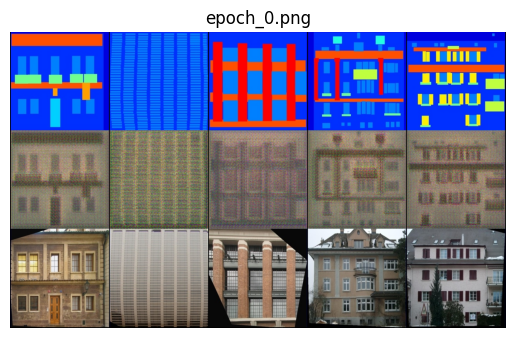

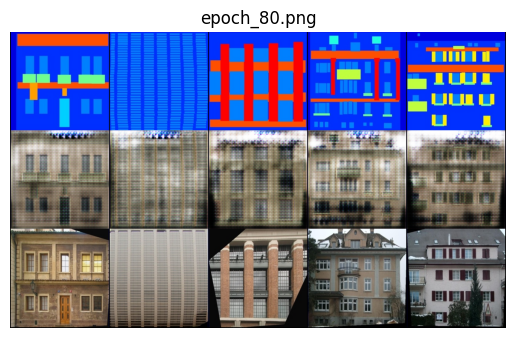

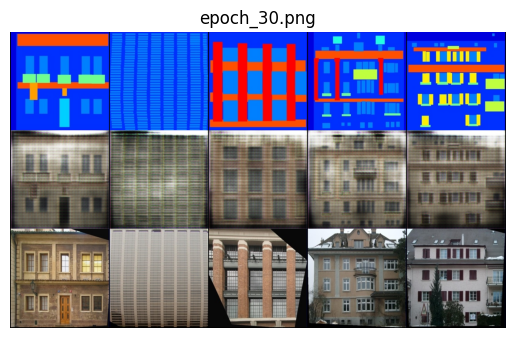

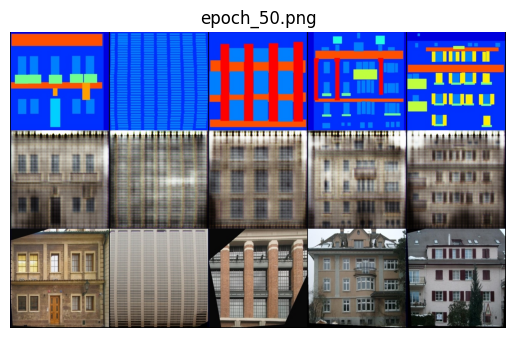

In [16]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your image folder
folder_path = '/content/images'

# Get list of all files in the folder
images = os.listdir(folder_path)

# Create subplots based on number of images

# Iterate and plot each image
for i, image_name in enumerate(images):
    # Construct full image path
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)
    plt.show()

